In [1]:
from datetime import date, timedelta, datetime

import pandas as pd
import numpy as np
import time
import lightgbm as lgb
#from com_util import *
import gc
import os
import xgboost as xgb
import lightgbm as lgb
from scipy import stats 
from sklearn.preprocessing import StandardScaler, LabelEncoder
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import GridSearchCV
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 
from sklearn import feature_selection
from catboost import CatBoostRegressor
from lightgbm.sklearn import LGBMRegressor
from sklearn.externals import joblib
from xgboost import plot_importance

from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config ZMQInteractiveShell.ast_node_interactivity='all'
%pprint

# 大小设置
sns.set(rc={'figure.figsize':(13,7)})
# 风格设置
sns.set_style("whitegrid")


plot = True

goal = 'price'
myid = 'SaleID'


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


Pretty printing has been turned OFF


### 简单处理看看：https://zhuanlan.zhihu.com/p/38622109

- 车龄前五年折旧率：16%、12%、10%、8%、6%，逐年价格
- 车分淡季旺季

In [2]:
# 大小设置
sns.set(rc={'figure.figsize':(13,7)})
# 风格设置
sns.set_style("whitegrid")

# 处理函数

In [3]:
##############################################
#encoding=utf8
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn import preprocessing

def encode_onehot(df,column_name):
    feature_df=pd.get_dummies(df[column_name], prefix=column_name)
    all = pd.concat([df.drop([column_name], axis=1),feature_df], axis=1)
    return all

def encode_count(df,column_name):
    lbl = preprocessing.LabelEncoder()
    lbl.fit(list(df[column_name].values))
    df[column_name] = lbl.transform(list(df[column_name].values))
    return df

def merge_count(df,columns,value,cname):
    add = pd.DataFrame(df.groupby(columns)[value].count()).reset_index()
    add.columns=columns+[cname]
    df=df.merge(add,on=columns,how="left")
    return df

def merge_nunique(df,columns,value,cname):
    add = pd.DataFrame(df.groupby(columns)[value].nunique()).reset_index()
    add.columns=columns+[cname]
    df=df.merge(add,on=columns,how="left")
    return df

def corr_plot(dt, topk=30):
    tmp = dt[dt.isTrain==1]
    cols = np.abs(tmp.corr()).nlargest(topk, 'price')['price'].index
    cn = np.corrcoef(tmp[cols].values.T)
    sns.heatmap(cn, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size':10},
                yticklabels=cols.values, 
                xticklabels=cols.values)

# 正式数据处理

In [4]:
df_train = pd.read_csv('../data/used_car_train_20200313.csv',sep=' ', parse_dates=['regDate', 'creatDate'])
df_test = pd.read_csv('../data/used_car_testA_20200313.csv', sep=' ', parse_dates=['regDate', 'creatDate'])
df_train["price"] = df_train["price"].apply(lambda x: np.log1p(float(x)) if float(x) > 0 else 0)
df_test["price"] = 0
df_train["isTrain"] = 1
df_test["isTrain"] = 0

dt = pd.concat([df_train, df_test], ignore_index=True)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


# 训练与测试泄露查看

In [5]:
check_var = ['name', 'regDate', 'model', 'brand', 'bodyType', 'fuelType',
       'gearbox', 'notRepairedDamage', 'regionCode', 'seller', 'offerType', 'creatDate']
for i in check_var:
    leni = len(set(df_test[i]) - set(df_train[i]))
    print('{col}测试集泄露样本数量为：'.format(col = i),leni)

name测试集泄露样本数量为： 28804
regDate测试集泄露样本数量为： 6
model测试集泄露样本数量为： 0
brand测试集泄露样本数量为： 0
bodyType测试集泄露样本数量为： 1413
fuelType测试集泄露样本数量为： 2893
gearbox测试集泄露样本数量为： 1910
notRepairedDamage测试集泄露样本数量为： 0
regionCode测试集泄露样本数量为： 116
seller测试集泄露样本数量为： 0
offerType测试集泄露样本数量为： 0
creatDate测试集泄露样本数量为： 5


## 日期

### 日期顺延

In [6]:
set(df_test.creatDate) - set(df_train.creatDate)
leak_date = ['2015-11-13 00:00:00', '2016-01-16 00:00:00', '2015-06-11 00:00:00', '2015-11-02 00:00:00', '2016-02-01 00:00:00']
for t in leak_date:
    t = datetime.strptime(t, "%Y-%m-%d %H:%M:%S")
    dt.loc[dt.creatDate==t, 'creatDate'] = t + timedelta(days=1)

{Timestamp('2015-11-13 00:00:00'), Timestamp('2015-06-11 00:00:00'), Timestamp('2016-02-01 00:00:00'), Timestamp('2016-01-16 00:00:00'), Timestamp('2015-11-02 00:00:00')}

In [7]:
dt["regYear"] = dt.regDate.apply(lambda x:x[:4]).astype(int)
dt["creatYear"] = dt.creatDate.apply(lambda x: x.year)
# 车售出距离当前天数
cur_date = np.max(dt.creatDate)
dt["salesDays"] = dt.creatDate.apply(lambda x: (cur_date-x).days)
# 车龄
dt["car_age"] = dt["creatYear"] - dt["regYear"]

del dt["regDate"]

dt["day_of_week"] = dt.creatDate.apply(lambda x: x.weekday()) + 1
dt["holiday"] = (dt["day_of_week"]>=6).astype(int)
holiday = ['2015-01-01', '2015-01-02', '2015-01-03', '2015-01-18', '2015-01-19', 
           '2015-01-20', '2015-01-21', '2015-01-22', '2015-01-23', '2015-01-24', 
           '2015-04-05', '2015-04-06', '2015-05-01', '2015-06-20', '2015-06-21', 
           '2015-06-22', '2015-09-27', '2015-10-01', '2015-10-02', '2015-10-03', 
           '2015-10-04', '2015-10-05', '2015-10-06', '2015-10-07', 
           '2016-01-01', '2016-01-02', '2016-01-03', '2016-02-07', '2016-02-08', 
           '2016-02-09', '2016-02-10', '2016-02-11', '2016-02-12', '2016-02-13', 
           '2016-04-04', '2016-04-05', '2016-04-06', '2016-05-01', '2016-05-02', 
           '2016-06-09', '2016-06-10', '2016-06-11', '2016-09-15', '2016-09-16', 
           '2016-09-17', '2016-10-01', '2016-10-02', '2016-10-03', '2016-10-04', 
           '2016-10-05', '2016-10-06', '2016-10-07']
no_holiday = ['2015-01-04', '2015-02-15', '2015-02-28', '2015-10-10', '2016-02-06', 
              '2016-02-14', '2016-06-12', '2016-09-18', '2016-10-08', '2016-10-09']

for i in holiday:
    dt.loc[dt.creatDate==i, "creatDate"] = 1
    

for i in no_holiday:
    dt.loc[dt.creatDate==i, "creatDate"] = 0
    
    
    
#生成sin/cos特征

dt['creatWeek_sin'] = np.sin(2 * np.pi * dt.day_of_week/7.0)
dt['creatWeek_cos'] = np.cos(2 * np.pi * dt.day_of_week/7.0)
dt['creatMonth_sin'] = np.sin(2 * np.pi * dt.creatDate.apply(lambda x: x.month)/12.0)
dt['creatMonth_cos'] = np.cos(2 * np.pi * dt.creatDate.apply(lambda x: x.month)/12.0)

dt['creatYearMonth'] = dt.creatDate.apply(lambda x: str(x)[:7])

In [8]:
# 一年的数据构造月级别的差分、同比、环比数据。


####### creatYearMonth_hit
creatYearMonth_hit = dt.creatYearMonth.value_counts().reset_index(inplace=False)
creatYearMonth_hit.columns = ['creatYearMonth', 'creatYearMonth_hit']

# creatYearMonth_hit一阶差分
sort_creatYearMonth_hit = creatYearMonth_hit.sort_values(by='creatYearMonth', ascending=True)
sort_creatYearMonth_hit_diff1 = [0] + list(np.array(sort_creatYearMonth_hit.creatYearMonth_hit[1:]) - np.array(sort_creatYearMonth_hit.creatYearMonth_hit[:-1]))
creatYearMonth_hit['creatYearMonth_hit_diff1'] = sort_creatYearMonth_hit_diff1
# creatYearMonth_hit上一月环比
sort_creatYearMonth_hit_huanbi = [1] + list(np.array(sort_creatYearMonth_hit.creatYearMonth_hit[1:]) / np.array(sort_creatYearMonth_hit.creatYearMonth_hit[:-1]))
creatYearMonth_hit['creatYearMonth_hit_huanbi'] = sort_creatYearMonth_hit_huanbi
dt = dt.merge(creatYearMonth_hit, how='left', on=['creatYearMonth'])




####### creatYearMonth_price
creatYearMonth_price = dt.loc[:,['creatYearMonth', 'price']].groupby(['creatYearMonth']).mean().reset_index(inplace=False)
creatYearMonth_price.columns = ['creatYearMonth', 'creatYearMonth_price']

# creatYearMonth_price一阶差分
sort_creatYearMonth_price = creatYearMonth_price.sort_values(by='creatYearMonth', ascending=True)
sort_creatYearMonth_price_diff1 = [0] + list(np.array(sort_creatYearMonth_price.creatYearMonth_price[1:]) - np.array(sort_creatYearMonth_price.creatYearMonth_price[:-1]))
creatYearMonth_price['creatYearMonth_price_diff1'] = sort_creatYearMonth_price_diff1
# creatYearMonth_price上一月环比
sort_creatYearMonth_price_huanbi = [1] + list(np.array(sort_creatYearMonth_price.creatYearMonth_price[1:]) / np.array(sort_creatYearMonth_price.creatYearMonth_price[:-1]))
creatYearMonth_price['creatYearMonth_price_huanbi'] = sort_creatYearMonth_price_huanbi
dt = dt.merge(creatYearMonth_price, how='left', on=['creatYearMonth'])

del dt['creatYearMonth']


##### 是否周末
dt['creatDate_is_Weekend'] = [1 if day in (0,6) else 0 for day in list(dt.creatDate.apply(lambda x: x.weekday()))]


In [9]:
# 一年的数据构造天级别的差分、同比、环比数据。

dt['creatDateStr'] = dt.creatDate.apply(lambda x: str(x)[:10])

####### creatDateStr_hit
creatDateStr_hit = dt.creatDateStr.value_counts().reset_index(inplace=False)
creatDateStr_hit.columns = ['creatDateStr', 'creatDateStr_hit']

# creatDateStr_hit一阶差分
sort_creatDateStr_hit = creatDateStr_hit.sort_values(by='creatDateStr', ascending=True)
sort_creatDateStr_hit_diff1 = [0] + list(np.array(sort_creatDateStr_hit.creatDateStr_hit[1:]) - np.array(sort_creatDateStr_hit.creatDateStr_hit[:-1]))
creatDateStr_hit['creatDateStr_hit_diff1'] = sort_creatDateStr_hit_diff1
# creatDateStr_hit上一月环比
sort_creatDateStr_hit_huanbi = [1] + list(np.array(sort_creatDateStr_hit.creatDateStr_hit[1:]) / np.array(sort_creatDateStr_hit.creatDateStr_hit[:-1]))
creatDateStr_hit['creatDateStr_hit_huanbi'] = sort_creatDateStr_hit_huanbi
dt = dt.merge(creatDateStr_hit, how='left', on=['creatDateStr'])




####### creatDateStr_price
creatDateStr_price = dt.loc[:,['creatDateStr', 'price']].groupby(['creatDateStr']).mean().reset_index(inplace=False)
creatDateStr_price.columns = ['creatDateStr', 'creatDateStr_price']

# creatDateStr_price一阶差分
sort_creatDateStr_price = creatDateStr_price.sort_values(by='creatDateStr', ascending=True)
sort_creatDateStr_price_diff1 = [0] + list(np.array(sort_creatDateStr_price.creatDateStr_price[1:]) - np.array(sort_creatDateStr_price.creatDateStr_price[:-1]))
creatDateStr_price['creatDateStr_price_diff1'] = sort_creatDateStr_price_diff1
# creatDateStr_price上一月环比
sort_creatDateStr_price_huanbi = [1] + list(np.array(sort_creatDateStr_price.creatDateStr_price[1:]) / np.array(sort_creatDateStr_price.creatDateStr_price[:-1]))
creatDateStr_price['creatDateStr_price_huanbi'] = sort_creatDateStr_price_huanbi
dt = dt.merge(creatDateStr_price, how='left', on=['creatDateStr'])

del dt['creatDateStr']


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide


In [10]:
dt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200000 entries, 0 to 199999
Data columns (total 54 columns):
SaleID                         200000 non-null int64
bodyType                       194081 non-null float64
brand                          200000 non-null int64
creatDate                      200000 non-null object
fuelType                       188427 non-null float64
gearbox                        192109 non-null float64
isTrain                        200000 non-null int64
kilometer                      200000 non-null float64
model                          199999 non-null float64
name                           200000 non-null int64
notRepairedDamage              200000 non-null object
offerType                      200000 non-null int64
power                          200000 non-null int64
price                          200000 non-null float64
regionCode                     200000 non-null int64
seller                         200000 non-null int64
v_0                        

In [11]:
#构造数据

def date_handle(dt):
    dt["day"]=dt.creatDate.apply(lambda x: x.day)
    days_of_months = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
    # Feiyang: 2. 新的特征 "days_to_side" 表示当天距离月初月末的最短距离
    dt["days_to_side"] = dt.creatDate.apply(
        lambda x: min(x.day, days_of_months[x.month-1]-x.day))
    # Feiyang: 3. 把月初月末的定义改成了7天
    dt["day"]=dt["day"].apply(lambda x:0 if x<=7 else 2 if x>=24 else 1)
    return dt

dt = date_handle(dt)

## 未知列降维

In [12]:
pca_feature = ['v_0', 'v_1', 'v_2', 'v_3', 'v_4', 'v_5', 'v_6', 'v_7', 'v_8', 'v_9', 'v_10', 'v_11', 'v_12','v_13', 'v_14']
X = dt[pca_feature]

# 标准化
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)
    
#进行降维，从多维降到5维
pca1 = PCA(n_components=5)
pca1.fit(X)

#返回所保留的n个成分各自的方差百分比
print(pca1.explained_variance_ratio_)
print(pca1.explained_variance_)

# 返回降维后的数据
pca_data=pca1.transform(X)

# 降维后的数据放回原数据
for i in range(len(pca_data[0])):
    dt['pca_'+str(i)] = pca_data.T[i]

dt.drop(labels=pca_feature, axis=1, inplace=True)

StandardScaler(copy=True, with_mean=True, with_std=True)

PCA(copy=True, iterated_power='auto', n_components=5, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

[0.30300202 0.22595997 0.20885951 0.18544691 0.06800049]
[4.54505298 3.38941646 3.13290835 2.78171757 1.02001239]


# 泄露处理

## name

[(0.999, 19.143], (0.999, 19.143], (0.999, 19.143], (0.999, 19.143], (0.999, 19.143], ..., (169.0, 378.0], (169.0, 378.0], (169.0, 378.0], (169.0, 378.0], (169.0, 378.0]]
Length: 128
Categories (7, interval[float64]): [(0.999, 19.143] < (19.143, 37.286] < (37.286, 55.429] < (55.429, 75.571] < (75.571, 103.714] < (103.714, 169.0] < (169.0, 378.0]]

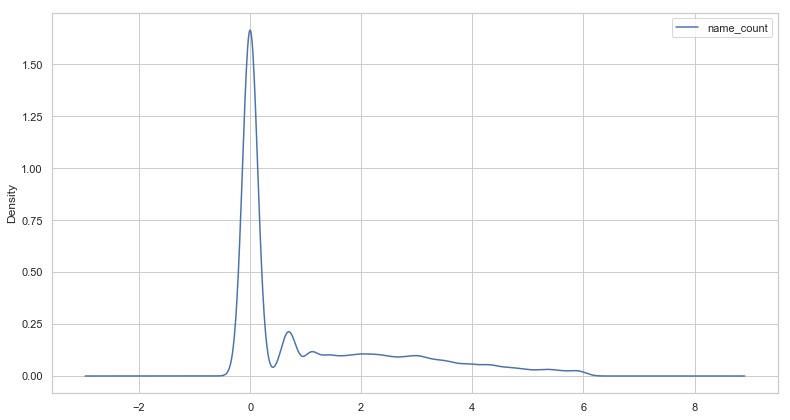

In [13]:
# name
# hit等频分组

name_col = dt.name.value_counts().reset_index(inplace=False)
name_col.columns = ['name', 'name_count']
dt = dt.merge(name_col, how='left', on=['name'])

np.log(dt[['name_count']]).plot.density()

name_count_qcut = pd.qcut(list(set(list(dt['name_count']))), 7) 
name_count_qcut


dt.loc[dt.name_count<=19.143, ['name_count']] = 0
dt.loc[(19.143<dt.name_count) & (dt.name_count<=37.286), ['name_count']] = 1
dt.loc[(37.286<dt.name_count) & (dt.name_count<=55.429), ['name_count']] = 2
dt.loc[(55.429<dt.name_count) & (dt.name_count<=75.571), ['name_count']] = 3 
dt.loc[(75.571<dt.name_count) & (dt.name_count<=103.714), ['name_count']] = 4
dt.loc[(103.714<dt.name_count) & (dt.name_count<=169.0), ['name_count']] = 5 
dt.loc[169.0<dt.name_count, ['name_count']] = 6

# 删除name列
dt.drop(['name'], axis=1, inplace=True)


# name_count价格

name_count_price = dt.loc[dt.isTrain==1, ['name_count','price']].groupby('name_count').agg(['mean', 'max', 'min', 'std']).reset_index()
name_count_price.columns = ['name_count', 'name_count_price_mean', 'name_count_price_max', 
                            'name_count_price_min', 'name_count_price_std']
dt = dt.merge(name_count_price, how='left', on=['name_count'])


## 缺失值

In [14]:
dt.bodyType.fillna(value=-1, inplace=True)
dt.fuelType.fillna(value=-1, inplace=True)
dt.gearbox.fillna(value=-1, inplace=True)
dt.model.fillna(value=stats.mode(dt.model)[0][0], inplace=True)


## 类别合并

In [15]:
# bodyType类别合并
dt.loc[(dt.bodyType==0) | (dt.bodyType==2), ['bodyType']] = 0
dt.loc[(dt.bodyType==4) | (dt.bodyType==5), ['bodyType']] = 4


# fuelType类别合并
# 合并之后与价格相关性不大
dt.loc[(dt.fuelType==0) | (dt.fuelType==2) | (dt.fuelType==5), ['fuelType']] = 0

## bodyType

- 值少

In [16]:
# bodyType
# 计算hit

bodyType_count = dt.bodyType.value_counts().reset_index(inplace=False)
bodyType_count.columns = ['bodyType', 'bodyType_count']
dt = dt.merge(bodyType_count, how='left', on=['bodyType'])

# 计算价格

bodyType_price = dt.loc[dt.isTrain==1, ['bodyType','price']].groupby('bodyType').agg(['mean', 'max', 'min', 'std']).reset_index()
bodyType_price.columns = ['bodyType', 'bodyType_price_mean', 'bodyType_price_max', 
                            'bodyType_price_min', 'bodyType_price_std']
dt = dt.merge(bodyType_price, how='left', on=['bodyType'])

## fuelType

- 值少

In [17]:
# fuelType
# 计算hit

fuelType_count = dt.fuelType.value_counts().reset_index(inplace=False)
fuelType_count.columns = ['fuelType', 'fuelType_count']
dt = dt.merge(fuelType_count, how='left', on=['fuelType'])

# 计算价格

fuelType_price = dt.loc[dt.isTrain==1, ['fuelType','price']].groupby('fuelType').agg(['mean', 'max', 'min', 'std']).reset_index()
fuelType_price.columns = ['fuelType', 'fuelType_price_mean', 'fuelType_price_max', 
                            'fuelType_price_min', 'fuelType_price_std']
dt = dt.merge(fuelType_price, how='left', on=['fuelType'])

## gearbox

- 值少

In [18]:
# gearbox
# 计算hit

gearbox_count = dt.gearbox.value_counts().reset_index(inplace=False)
gearbox_count.columns = ['gearbox', 'gearbox_count']
dt = dt.merge(gearbox_count, how='left', on=['gearbox'])

# 计算价格

gearbox_price = dt.loc[dt.isTrain==1, ['gearbox','price']].groupby('gearbox').agg(['mean', 'max', 'min', 'std']).reset_index()
gearbox_price.columns = ['gearbox', 'gearbox_price_mean', 'gearbox_price_max', 
                            'gearbox_price_min', 'gearbox_price_std']
dt = dt.merge(gearbox_price, how='left', on=['gearbox'])

## regionCode

[(0.999, 31.8], (0.999, 31.8], (124.2, 515.0], (0.999, 31.8], (0.999, 31.8], ..., (124.2, 515.0], (124.2, 515.0], (124.2, 515.0], (124.2, 515.0], (124.2, 515.0]]
Length: 155
Categories (5, interval[float64]): [(0.999, 31.8] < (31.8, 62.6] < (62.6, 93.4] < (93.4, 124.2] < (124.2, 515.0]]

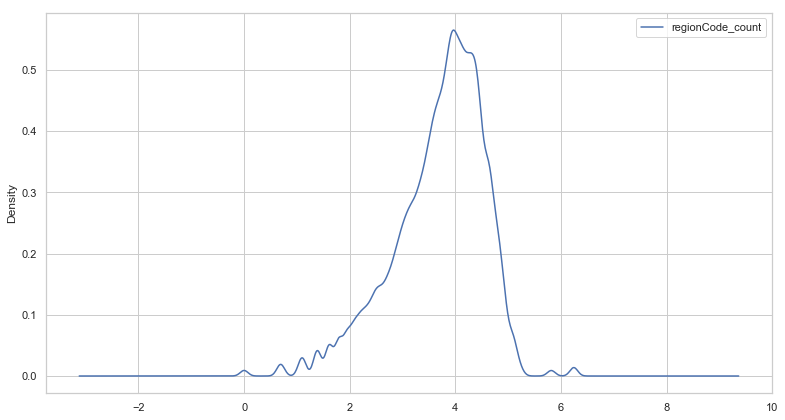

In [19]:
# regionCode
# hit等频分组

regionCode_col = dt.regionCode.value_counts().reset_index(inplace=False)
regionCode_col.columns = ['regionCode', 'regionCode_count']
dt = dt.merge(regionCode_col, how='left', on=['regionCode'])

np.log(dt[['regionCode_count']]).plot.density()

regionCode_count_qcut = pd.qcut(list(set(list(dt['regionCode_count']))), 5) 
regionCode_count_qcut

dt.loc[dt.regionCode_count<=31.8, ['regionCode_count']] = 0
dt.loc[(31.8<dt.regionCode_count) & (dt.regionCode_count<=62.6), ['regionCode_count']] = 1
dt.loc[(62.6<dt.regionCode_count) & (dt.regionCode_count<=93.4), ['regionCode_count']] = 2
dt.loc[(93.4<dt.regionCode_count) & (dt.regionCode_count<=124.2), ['regionCode_count']] = 3
dt.loc[124.2<dt.regionCode_count, ['regionCode_count']] = 4

# 删除regionCode列
dt.drop(['regionCode'], axis=1, inplace=True)

# regionCode_count价格

regionCode_count_price = dt.loc[dt.isTrain==1, ['regionCode_count','price']].groupby('regionCode_count').agg(['mean', 'max', 'min', 'std']).reset_index()
regionCode_count_price.columns = ['regionCode_count', 'regionCode_count_price_mean', 'regionCode_count_price_max', 
                            'regionCode_count_price_min', 'regionCode_count_price_std']
dt = dt.merge(regionCode_count_price, how='left', on=['regionCode_count'])

## 车龄

In [20]:
set(dt[dt.isTrain==0].car_age) - set(dt[dt.isTrain==1].car_age)

{0}

In [21]:
dt.loc[dt.car_age==0, 'car_age'] = 1

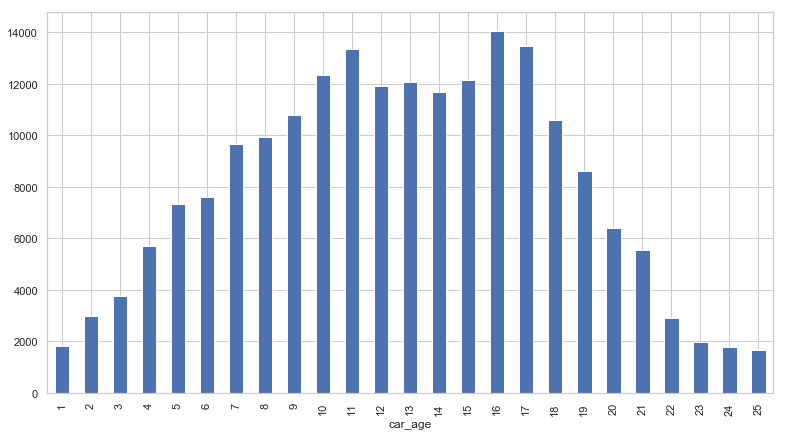

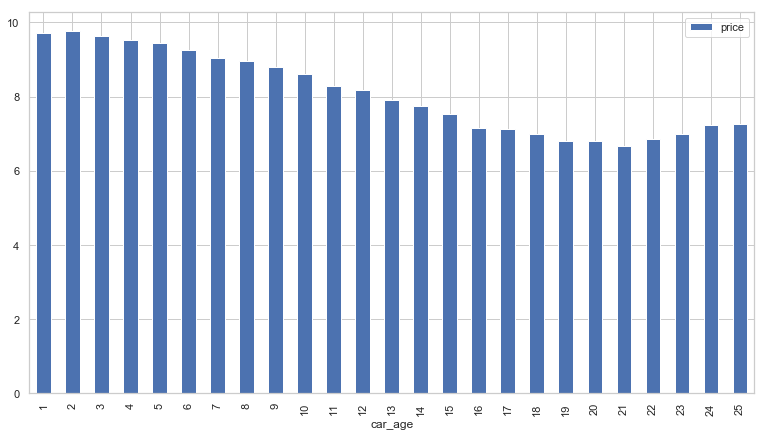

In [22]:
dt[['car_age']].groupby('car_age').size().plot.bar()
dt.loc[dt.isTrain==1, ['car_age','price']].groupby('car_age').mean().plot.bar()

## car_age对价格影响大，增加对应车龄的平均价格

In [23]:
car_age_avg_price = dt.loc[dt.isTrain==1, ['car_age','price']].groupby('car_age').mean().reset_index()
car_age_avg_price.columns = ['car_age', 'car_age_avg_price']
dt = dt.merge(car_age_avg_price, how='left', on=['car_age'])


## 类别hit与price分桶

### model

[(0.999, 70.714], (0.999, 70.714], (349.857, 559.857], (0.999, 70.714], (0.999, 70.714], ..., (349.857, 559.857], (349.857, 559.857], (349.857, 559.857], (559.857, 1606.143], (1606.143, 15659.0]]
Length: 207
Categories (7, interval[float64]): [(0.999, 70.714] < (70.714, 139.571] < (139.571, 216.571] < (216.571, 349.857] < (349.857, 559.857] < (559.857, 1606.143] < (1606.143, 15659.0]]

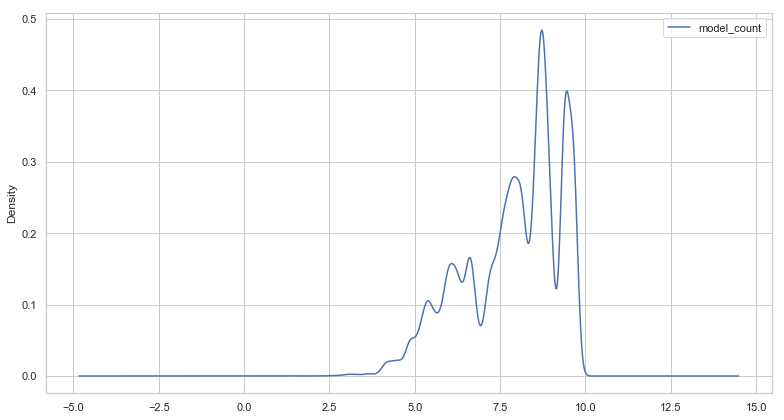

In [24]:
# model
# hit等频分组

model_col = dt.model.value_counts().reset_index(inplace=False)
model_col.columns = ['model', 'model_count']
dt = dt.merge(model_col, how='left', on=['model'])

np.log(dt[['model_count']]).plot.density()

model_count_qcut = pd.qcut(list(set(list(dt['model_count']))), 7) 
model_count_qcut

dt.loc[dt.model_count<=70.714, ['model_count']] = 0
dt.loc[(70.714<dt.model_count) & (dt.model_count<=139.571), ['model_count']] = 1
dt.loc[(139.571<dt.model_count) & (dt.model_count<=216.571), ['model_count']] = 2
dt.loc[(216.571<dt.model_count) & (dt.model_count<=349.857), ['model_count']] = 3 
dt.loc[(349.857<dt.model_count) & (dt.model_count<=559.857), ['model_count']] = 4
dt.loc[(559.857<dt.model_count) & (dt.model_count<=1606.143), ['model_count']] = 5 
dt.loc[1606.143<dt.model_count, ['model_count']] = 6

0         (6.635, 7.312]
1         (7.988, 8.664]
2          (8.664, 9.34]
3          (8.664, 9.34]
4         (6.635, 7.312]
               ...      
199995    (7.988, 8.664]
199996    (7.312, 7.988]
199997    (7.988, 8.664]
199998     (8.664, 9.34]
199999    (7.312, 7.988]
Name: model_price, Length: 200000, dtype: category
Categories (7, interval[float64]): [(5.954, 6.635] < (6.635, 7.312] < (7.312, 7.988] < (7.988, 8.664] < (8.664, 9.34] < (9.34, 10.017] < (10.017, 10.693]]

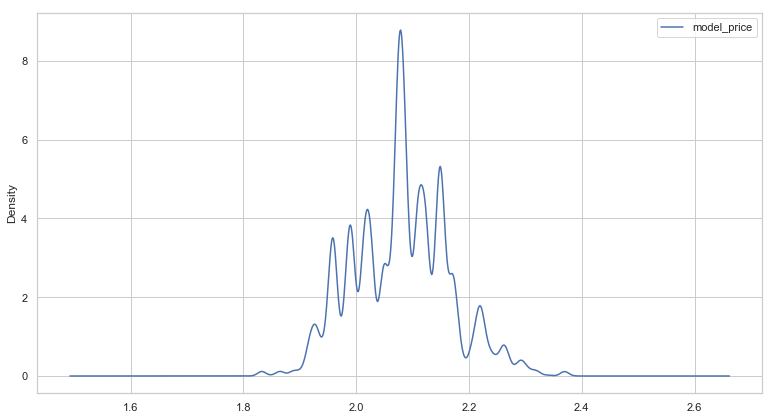

In [25]:
# model
# 价格等距分组


model_price = dt.loc[dt.isTrain==1, ['model','price']].groupby('model').mean().reset_index()
model_price.columns = ['model', 'model_price']
dt = dt.merge(model_price, how='left', on=['model'])

np.log(dt[['model_price']]).plot.density()

model_cut = pd.cut(dt.model_price, 7) 
model_cut


dt['model_price_backet'] = dt['model_price']
dt.loc[dt.model_price_backet<=6.635, ['model_price_backet']] = 0
dt.loc[(6.635<dt.model_price_backet) & (dt.model_price_backet<=7.312), ['model_price_backet']] = 1
dt.loc[(7.312<dt.model_price_backet) & (dt.model_price_backet<=7.988), ['model_price_backet']] = 2
dt.loc[(7.988<dt.model_price_backet) & (dt.model_price_backet<=8.664), ['model_price_backet']] = 3
dt.loc[(8.664<dt.model_price_backet) & (dt.model_price_backet<=9.34), ['model_price_backet']] = 4
dt.loc[(9.34<dt.model_price_backet) & (dt.model_price_backet<=10.017), ['model_price_backet']] = 5
dt.loc[10.017<dt.model_price_backet, ['model_price_backet']] = 6


# dt.drop(['model'], axis=1, inplace=True)

### brand

[(3167.143, 12009.0], (298.857, 747.571], (10.999, 298.857], (2056.143, 3167.143], (747.571, 1320.143], ..., (10.999, 298.857], (747.571, 1320.143], (747.571, 1320.143], (747.571, 1320.143], (10.999, 298.857]]
Length: 39
Categories (7, interval[float64]): [(10.999, 298.857] < (298.857, 747.571] < (747.571, 1320.143] < (1320.143, 2056.143] < (2056.143, 3167.143] < (3167.143, 12009.0] < (12009.0, 41828.0]]

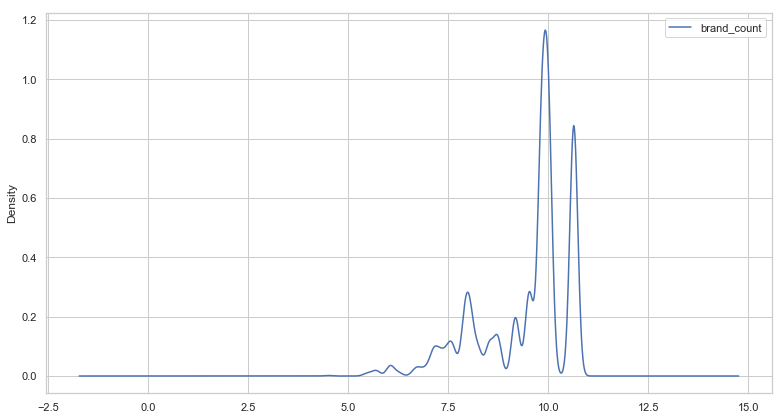

In [26]:
# brand
# hit等频分组

brand_col = dt.brand.value_counts().reset_index(inplace=False)
brand_col.columns = ['brand', 'brand_count']
dt = dt.merge(brand_col, how='left', on=['brand'])

np.log(dt[['brand_count']]).plot.density()

brand_count_qcut = pd.qcut(list(set(list(dt['brand_count']))), 7) 
brand_count_qcut

dt.loc[dt.brand_count<=298.857, ['brand_count']] = 0
dt.loc[(298.857<dt.brand_count) & (dt.brand_count<=747.571), ['brand_count']] = 1
dt.loc[(747.571<dt.brand_count) & (dt.brand_count<=1320.143), ['brand_count']] = 2
dt.loc[(1320.143<dt.brand_count) & (dt.brand_count<=2056.143), ['brand_count']] = 3 
dt.loc[(2056.143<dt.brand_count) & (dt.brand_count<=3167.143), ['brand_count']] = 4
dt.loc[(3167.143<dt.brand_count) & (dt.brand_count<=12009.0), ['brand_count']] = 5 
dt.loc[12009.0<dt.brand_count, ['brand_count']] = 6

0         (7.248, 7.745]
1         (8.242, 8.739]
2         (8.739, 9.236]
3         (8.242, 8.739]
4         (7.248, 7.745]
               ...      
199995    (8.242, 8.739]
199996    (7.745, 8.242]
199997    (8.242, 8.739]
199998    (8.242, 8.739]
199999    (7.248, 7.745]
Name: brand_price, Length: 200000, dtype: category
Categories (7, interval[float64]): [(6.747, 7.248] < (7.248, 7.745] < (7.745, 8.242] < (8.242, 8.739] < (8.739, 9.236] < (9.236, 9.733] < (9.733, 10.231]]

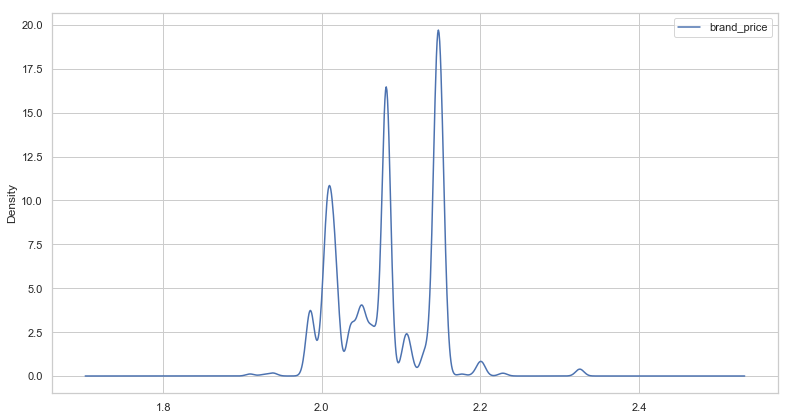

In [27]:
# brand
# 价格等距分组


brand_price = dt.loc[dt.isTrain==1, ['brand','price']].groupby('brand').mean().reset_index()
brand_price.columns = ['brand', 'brand_price']
dt = dt.merge(brand_price, how='left', on=['brand'])

np.log(dt[['brand_price']]).plot.density()

brand_cut = pd.cut(dt.brand_price, 7) 
brand_cut

dt['brand_price_backet'] = dt['brand_price']
dt.loc[dt.brand_price_backet<=7.248, ['brand_price_backet']] = 0
dt.loc[(7.248<dt.brand_price_backet) & (dt.brand_price_backet<=7.745), ['brand_price_backet']] = 1
dt.loc[(7.745<dt.brand_price_backet) & (dt.brand_price_backet<=8.242), ['brand_price_backet']] = 2
dt.loc[(8.242<dt.brand_price_backet) & (dt.brand_price_backet<=8.739), ['brand_price_backet']] = 3
dt.loc[(8.739<dt.brand_price_backet) & (dt.brand_price_backet<=9.236), ['brand_price_backet']] = 4
dt.loc[(9.236<dt.brand_price_backet) & (dt.brand_price_backet<=9.733), ['brand_price_backet']] = 5
dt.loc[9.733<dt.brand_price_backet, ['brand_price_backet']] = 6



# dt.drop(['brand'], axis=1, inplace=True)


## top30指标

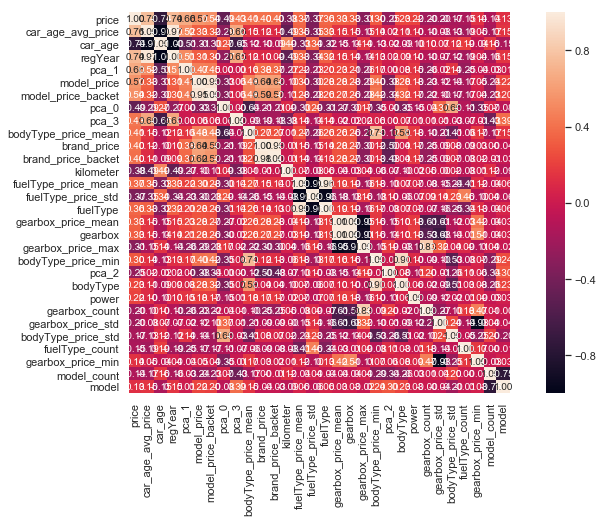

In [28]:
corr_plot(topk=30, dt=dt)

# 删除列

- 取值单一或者已经用此提取过其他特征

In [29]:
dt.drop(['creatDate', 'regYear', 'creatYear', 'seller', 'offerType'], axis=1, inplace=True)

# 编码

In [30]:
# def encode_process(dt=dt, m_type = 'xgb-model'):
#     """
#         加载数据，输出放入模型的特征features列表以及特征列表中是类别型的列表cate_feat
#         对cate_feat进行了LabelEncoder，针对LGB增加category转化
#     """
#     # 参考资料：树模型LabelEncoder——https://www.cnblogs.com/ranjiewen/p/9105954.html:
    
#     lec = ['bodyType', 'fuelType', 'gearbox', 'notRepairedDamage', 'holiday', 'creatDate_is_Weekend']
#     lbl = LabelEncoder()  
#     for col in lec:
#         dt[col] = lbl.fit_transform(dt[col].astype(str))
#     if m_type == 'lgb-model':
#         for i in lec:
#             dt[i] = dt[i].astype('category')       
#     return dt

# dt = encode_process()

# 对数处理

In [31]:
dt.loc[:,['kilometer']] = dt[['kilometer']].apply(lambda x: np.log(x + 1))
dt.loc[:,['power']] = dt[['power']].apply(lambda x: np.log(x + 1))

In [32]:
dt.columns

Index(['SaleID', 'bodyType', 'brand', 'fuelType', 'gearbox', 'isTrain',
       'kilometer', 'model', 'notRepairedDamage', 'power', 'price',
       'salesDays', 'car_age', 'day_of_week', 'holiday', 'creatWeek_sin',
       'creatWeek_cos', 'creatMonth_sin', 'creatMonth_cos',
       'creatYearMonth_hit', 'creatYearMonth_hit_diff1',
       'creatYearMonth_hit_huanbi', 'creatYearMonth_price',
       'creatYearMonth_price_diff1', 'creatYearMonth_price_huanbi',
       'creatDate_is_Weekend', 'creatDateStr_hit', 'creatDateStr_hit_diff1',
       'creatDateStr_hit_huanbi', 'creatDateStr_price',
       'creatDateStr_price_diff1', 'creatDateStr_price_huanbi', 'day',
       'days_to_side', 'pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4',
       'name_count', 'name_count_price_mean', 'name_count_price_max',
       'name_count_price_min', 'name_count_price_std', 'bodyType_count',
       'bodyType_price_mean', 'bodyType_price_max', 'bodyType_price_min',
       'bodyType_price_std', 'fuelType_count', 'fuel

# 数据加载

In [33]:
def load_data(dt=dt, m_type = 'xgb-model'):
    """
        加载数据，输出放入模型的特征features列表以及特征列表中是类别型的列表cate_feat
        对cate_feat进行了LabelEncoder，针对LGB增加category转化
    """
    # 参考资料：树模型LabelEncoder——https://www.cnblogs.com/ranjiewen/p/9105954.html:

    noise_feature = [myid, goal, 'isTrain']
    category_feature = ['bodyType', 'brand', 'fuelType', 'gearbox', 'model', 'notRepairedDamage', 
                        'day_of_week', 'holiday','creatDate_is_Weekend']
    numeric_feature = [i for i in dt.columns if i not in category_feature + noise_feature]
    
    lbl = LabelEncoder()  
    for col in category_feature:
        dt[col] = lbl.fit_transform(dt[col].astype(str))
    if m_type == 'lgb-model':
        for catf in category_feature:
            dt[catf] = dt[catf].astype('category')         
    features = numeric_feature + category_feature
    train = dt[dt.isTrain==1]
    test = dt[dt.isTrain==0]


    return (train, test, features, category_feature)

# 训练与分析

In [34]:
# 参考：https://www.cnblogs.com/lvpengbo/p/8822318.html
# https://mathpretty.com/10649.html
# https://www.cnblogs.com/bjwu/p/9307344.html
# https://stackoverflow.com/questions/49774825/python-lightgbm-cross-validation-how-to-use-lightgbm-cv-for-regression

def modelfit(Regressor, train, test, features, category_feature, m_type='lgb-model', 
             useTrainCV=True, cv_folds=5, early_stopping_rounds=20):
    
    if useTrainCV:
        if m_type=='lgb-model':
            dtrain = lgb.Dataset(data=train[features], label=train[goal], 
                                 feature_name =features, categorical_feature=category_feature)
            lgb_param = Regressor.get_params()
            lgb_cvresult = lgb.cv(lgb_param, 
                              dtrain,
                              num_boost_round=Regressor.get_params()['n_estimators'], 
                              nfold=cv_folds, 
                              metrics='mae',
                              early_stopping_rounds=early_stopping_rounds, 
                              verbose_eval=500, 
                              show_stdv=False, 
                              seed=202001, 
                              callbacks=None,
                              # 回归问题设置为False 
                              stratified=False,
                              shuffle=True,
                              feature_name =features, categorical_feature=category_feature)
            print(len(lgb_cvresult['l1-mean']))
            Regressor.set_params(n_estimators=len(lgb_cvresult['l1-mean']))
        elif m_type=='xgb-model':
            dtrain = xgb.DMatrix(train[features], train[goal])
            xgb_param = Regressor.get_xgb_params()
            xgb_cvresult = xgb.cv(xgb_param, 
                              dtrain,
                              num_boost_round=Regressor.get_params()['n_estimators'], 
                              nfold=cv_folds, 
                              metrics='mae',
                              early_stopping_rounds=early_stopping_rounds, 
                              verbose_eval=500, 
                              show_stdv=False, 
                              seed=202002, 
                              callbacks=None, 
                              shuffle=True)
            Regressor.set_params(n_estimators=xgb_cvresult.shape[0])
        
        
    #Fit the algorithm on the data
    if m_type=='lgb-model':
        Regressor.fit(train[features], train[goal], eval_metric='mae',
                      feature_name=features, categorical_feature=category_feature)
    elif m_type=='xgb-model':
        Regressor.fit(train[features], train[goal], eval_metric='mae')
 
    #Predict training set:
    dtrain_predictions = Regressor.predict(train[features])
 
    #Print model report:
    print("\n=>Model Report")
    print("\n=>train====>mean-absolute-error : %.4g" % mean_absolute_error(np.exp(train[goal].values)-1, 
                                                             np.exp(dtrain_predictions)-1
                                                            ))
    print("\n=>submission result predict:")
    test_predictions = Regressor.predict(test[features])
    submission = pd.DataFrame({myid: test[myid], goal: np.int64(np.exp(test_predictions) - 1)})

    #Save result
    print("\n=>saving submission csv:")
    if not os.path.exists('result/'):
        os.makedirs('result/')
    submission.to_csv("./result/sample_submit11111.csv", index=False)

    #Save model
    print("\n=>saving model:")
    if m_type=='lgb-model':
        if not os.path.exists('model/'):
            os.makedirs('model/')
        joblib.dump(Regressor, "./model/lgbregressor_model.pkl")
        lgb.plot_importance(Regressor)
    elif m_type=='xgb-model':
        if not os.path.exists('model/'):
            os.makedirs('model/')
        joblib.dump(Regressor, "./model/xgbregressor_model.pkl")
        xgb.plot_importance(Regressor)

    #Plot feature importance 
    print("\n=>Plot feature importance:")
    plt.show()

# XGB

In [80]:
print("=> 载入数据中...")
# train, test, features, category_feature = load_data(dt=dt, m_type='xgb-model')
print("Train的info...", train.info())
mean_val = test['car_age_avg_price'].mean()
test['car_age_avg_price'].fillna(mean_val, inplace=True)

# 忽略特征

ignore_col = ['creatYearMonth_hit_diff1', 'creatYearMonth_price_huanbi', 'creatYearMonth_price', 
              'fuelType_price_max', 'gearbox', 'creatYearMonth_price_diff1', 'fuelType', 
              'creatYearMonth_hit', 'creatMonth_sin', 'creatMonth_cos', 'gearbox_price_min', 
              'gearbox_price_std', 'fuelType_price_std', 'holiday', 'fuelType_price_min', 'gearbox_price_max']

features =  [i for i in features if i not in ignore_col]

category_feature = [i for i in category_feature if i not in ignore_col]


print("=> 建模特征列：", features)
print("=> 建模类别特征列：", category_feature)


print("=> 使用XGB建模...")  

=> 载入数据中...
<class 'pandas.core.frame.DataFrame'>
Int64Index: 150000 entries, 0 to 149999
Data columns (total 71 columns):
SaleID                         150000 non-null int64
bodyType                       150000 non-null int32
brand                          150000 non-null int32
fuelType                       150000 non-null int32
gearbox                        150000 non-null int32
isTrain                        150000 non-null int64
kilometer                      150000 non-null float64
model                          150000 non-null int32
notRepairedDamage              150000 non-null int32
power                          150000 non-null float64
price                          150000 non-null float64
salesDays                      150000 non-null int64
car_age                        150000 non-null int64
day_of_week                    150000 non-null int32
holiday                        150000 non-null int32
creatWeek_sin                  150000 non-null float64
creatWeek_cos        

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:6287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [81]:
# 大小设置
sns.set(rc={'figure.figsize':(13,10)})
# 风格设置
sns.set_style("whitegrid")

In [ ]:
xgbRegr = XGBRegressor(
    learning_rate =0.05,
    n_estimators=5000,
    max_depth = 9,
    min_child_weight=1,
    reg_alpha= 0.7,
    reg_lambda= 0.01,
    gamma=0,
    subsample=0.9,
    colsample_bytree=0.8,
    objective= 'reg:linear',
    seed=202001)
print('XGB交叉验证...')
xgb_param = xgbRegr.get_xgb_params()
dtrain = xgb.DMatrix(train[features], train[goal])
cvresult = xgb.cv(xgb_param, 
                  dtrain,
                  num_boost_round=xgbRegr.get_params()['n_estimators'], 
                  nfold=3, 
                  metrics='mae',
                  early_stopping_rounds=20, 
                  verbose_eval=500, 
                  show_stdv=False, 
                  seed=202002, 
                  callbacks=None, 
                  shuffle=True)
xgbRegr.set_params(n_estimators=cvresult.shape[0])
print('XGB训练...')
xgbRegr.fit(train[features], train[goal], eval_metric='mae')
print('训练集MAE：', np.mean(abs( (np.exp(xgbRegr.predict(train[features])) - 1) - (np.exp(train[goal]) - 1) ) ))
print('XGB迭代次数...', xgbRegr.n_estimators)
print('XGB测试集预测...')
xgb_price_pre = np.exp(xgbRegr.predict(test[features])) - 1

#Plot feature importance 
print('XGB的特征重要性...')
plot_importance(xgbRegr)
plt.show()

XGB交叉验证...
[0]	train-mae:7.15861	test-mae:7.1586
[500]	train-mae:0.0847737	test-mae:0.131358
[1000]	train-mae:0.060169	test-mae:0.127779
[1500]	train-mae:0.0458827	test-mae:0.126236
[2000]	train-mae:0.0365997	test-mae:0.125417
[2500]	train-mae:0.030436	test-mae:0.124919


In [51]:
xgb6 = pd.read_csv('result/sample_submit6.csv')
xgb12 = pd.read_csv('result/sample_submit12.csv')
xgb13 = pd.read_csv('result/sample_submit13.csv')
xgb14 = pd.read_csv('result/sample_submit14.csv')
xgb15 = pd.read_csv('result/sample_submit15.csv')
xgb16 = pd.read_csv('result/sample_submit16.csv')
cat18 = pd.read_csv('result/sample_submit18-cat-notgood.csv')
cat19 = pd.read_csv('result/sample_submit19-cat-notverygood.csv')
cat20 = pd.read_csv('result/sample_submit20-cat-notveryverygood.csv')
lgb20 = pd.read_csv('result/sample_submit_lgb20_用于融合.csv')


xgb16_cat20 = pd.read_csv('result/sample_submit20-catboost与xgb16融合-466.csv')



In [52]:
np.mean(abs(xgb6.price.values-xgb_price_pre))
np.mean(abs(xgb12.price.values-xgb_price_pre))
np.mean(abs(xgb13.price.values-xgb_price_pre))
np.mean(abs(xgb14.price.values-xgb_price_pre))
np.mean(abs(xgb15.price.values-xgb_price_pre))
np.mean(abs(xgb16.price.values-xgb_price_pre))
np.mean(abs(cat18.price.values-xgb_price_pre))
np.mean(abs(cat19.price.values-xgb_price_pre))
np.mean(abs(cat20.price.values-xgb_price_pre))
np.mean(abs(lgb20.price.values-xgb_price_pre))
np.mean(abs(xgb16_cat20.price.values-xgb_price_pre))

333.73604911529543

371.35448335289004

342.7163897756958

355.78681553520204

321.6509245622253

309.1571070967865

409.71409706703184

324.94406094566347

304.9785615082931

312.93665085975647

271.256320850296

In [53]:
merge_xgb_cat_lgb = (cat20.price.values + lgb20.price.values + xgb_price_pre)/3

In [57]:
gc = pd.DataFrame({'xgb6':xgb6.price, 'xgb12':xgb12.price, 'xgb13':xgb13.price, 'xgb14':xgb14.price, 
                   'xgb15':xgb15.price, 'xgb16':xgb16.price, 'cat18':cat18.price, 'cat19':cat19.price, 'cat20':cat20.price, 
                   'lgb20':lgb20.price, 'xgb20':xgb_price_pre, 'xgb16_cat20':xgb16_cat20.price, 
                   'merge_xgb_cat_lgb':merge_xgb_cat_lgb})
gc.corr()

,xgb6,xgb12,xgb13,xgb14,xgb15,xgb16,cat18,cat19,cat20,lgb20,xgb20,xgb16_cat20,merge_xgb_cat_lgb
xgb6,1.000000,0.997755,0.998307,0.996765,0.998494,0.998430,0.991291,0.994400,0.994944,0.994287,0.994930,0.997847,0.996077
xgb12,0.997755,1.000000,0.996968,0.995258,0.997011,0.997164,0.990018,0.993412,0.993812,0.992963,0.993622,0.996647,0.994820
xgb13,0.998307,0.996968,1.000000,0.996504,0.997931,0.998138,0.992023,0.994774,0.995234,0.994486,0.994710,0.997845,0.996166
xgb14,0.996765,0.995258,0.996504,1.000000,0.996143,0.996567,0.991490,0.994070,0.994415,0.993909,0.994199,0.996648,0.995530
xgb15,0.998494,0.997011,0.997931,0.996143,1.000000,0.998591,0.991003,0.994569,0.995112,0.994565,0.995116,0.998012,0.996288
xgb16,0.998430,0.997164,0.998138,0.996567,0.998591,1.000000,0.991662,0.994909,0.995375,0.994768,0.995545,0.998851,0.996587
cat18,0.991291,0.990018,0.992023,0.991490,0.991003,0.991662,1.000000,0.996936,0.995906,0.994064,0.991723,0.994928,0.995250
cat19,0.994400,0.993412,0.994774,0.994070,0.994569,0.994909,0.996936,1.000000,0.998366,0.996664,0.994715,0.997785,0.997937
cat20,0.994944,0.993812,0.995234,0.994415,0.995112,0.995375,0.995906,0.998366,1.000000,0.996840,0.995240,0.998835,0.998716
lgb20,0.994287,0.992963,0.994486,0.993909,0.994565,0.994768,0.994064,0.996664,0.996840,1.000000,0.995674,0.996954,0.998864


In [56]:
(39108+34563)/2 # xgb16与cat20融合的结果

36835.5

In [58]:
gc.head(20)

,xgb6,xgb12,xgb13,xgb14,xgb15,xgb16,cat18,cat19,cat20,lgb20,xgb20,xgb16_cat20,merge_xgb_cat_lgb
0,37247,36016,37659,38284,38232,39108,32527,33887,34563,33445,32894.953125,36835,33634.317708
1,327,338,328,338,329,329,326,320,328,323,337.564362,328,329.521454
2,6135,6046,5857,5946,5726,5679,7315,6242,5902,5485,6315.395996,5790,5900.798665
3,11484,12496,12410,13474,11744,12084,13106,12592,12450,12517,10719.110352,12267,11895.370117
4,644,642,633,649,648,649,600,641,647,622,653.938232,648,640.979411
5,2051,1837,2246,2370,1963,1773,1860,1838,1721,1679,1748.055542,1747,1716.018514
6,4793,4789,4836,4702,4787,4812,4744,4788,4732,4633,4678.188965,4772,4681.062988
7,10133,10662,9600,10851,9737,9803,9478,9634,9681,9174,11224.989258,9742,10026.663086
8,1826,1849,2108,2314,2427,2131,2917,2717,2420,2165,2710.227051,2275,2431.742350
9,2169,2124,2100,2145,2186,2149,2174,2147,2156,2131,2100.197754,2152,2129.065918


In [74]:
submission = pd.DataFrame({myid: test[myid], goal: np.int64(3/6*xgb16.price+2/6*cat20.price+1/6*lgb20.price)})

In [75]:
submission.to_csv("./result/sample_submit.csv", index=False)

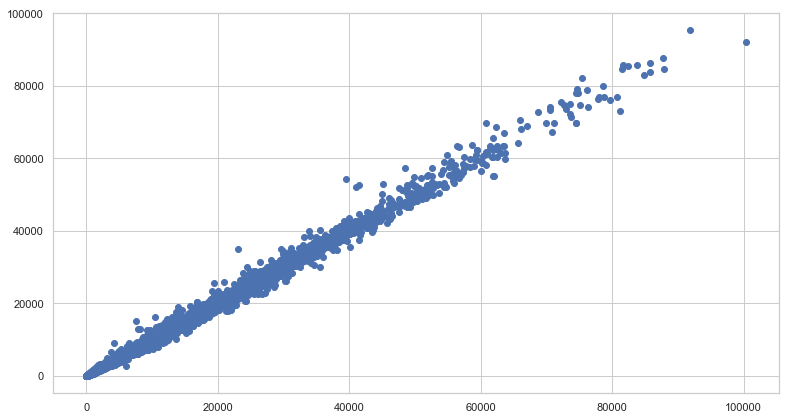

In [79]:
# 大小设置
sns.set(rc={'figure.figsize':(13,7)})
# 风格设置
sns.set_style("whitegrid")
plt.scatter(cat20.price, submission.price)

In [73]:
np.std((xgb16_cat20.price - (2/3*xgb16.price+1/3*cat20.price)))

117.948441453336

In [70]:
np.std((xgb16_cat20.price - (3/6*xgb16.price+2/6*cat20.price+1/6*lgb20.price)))

97.1054176625143

In [72]:
np.std((xgb16_cat20.price - (2/5*xgb16.price+2/5*cat20.price+1/5*lgb20.price)))

114.45916717305042

In [76]:
def get_big_diff_index(data1=xgb15, data2=test):
    diff_val = pd.DataFrame(data1.price.values - data2.price1.values)
    diff_val.columns = ['diffcol']
    a = diff_val[(diff_val['diffcol']>pd.Series(diff_val.diffcol.values).quantile(0.99)) | (diff_val['diffcol']<pd.Series(diff_val.diffcol.values).quantile(0.01))].index.tolist()
    return a

In [86]:
xgb15_16 = get_big_diff_index(data1=xgb15, data2=test)
xgb14_16 = get_big_diff_index(data1=xgb14, data2=test)
xgb13_16 = get_big_diff_index(data1=xgb13, data2=test)
xgb12_16 = get_big_diff_index(data1=xgb12, data2=test)
xgb6_16 = get_big_diff_index(data1=xgb6, data2=test)

In [88]:
set(xgb15_16) & set(xgb14_16) & set(xgb13_16) & set(xgb12_16) & set(xgb6_16)

{45571, 4102, 17414, 14347, 10259, 40469, 47126, 28189, 40483, 34859, 37938, 49716, 22081, 11848, 32843, 40012, 26703, 23637, 23133, 23134, 20575, 43616, 48741, 2662, 13433, 22149, 6790, 28296, 26265, 30879, 20132, 12982, 33463, 2752, 7874, 20167, 13512, 21193, 44235, 42190, 27350, 38116, 23269, 9447, 758, 41719, 28409, 47868, 15106, 45828, 19716, 24333, 24334, 48913, 278, 5922, 10539, 13624, 42302, 40259, 33094, 44360, 34637, 46420, 22869, 1367, 24921, 29017, 14683, 18265, 13154, 8037, 38763, 28538, 17787, 42880, 11138, 19332, 27531, 8593, 32659, 32662, 18843, 18858, 27052, 43442, 435, 26546, 43445, 36282, 39355, 21949, 33215, 36302, 38864, 20436, 3541, 29656, 12761, 11739, 22499, 2533, 20986, 15868}

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


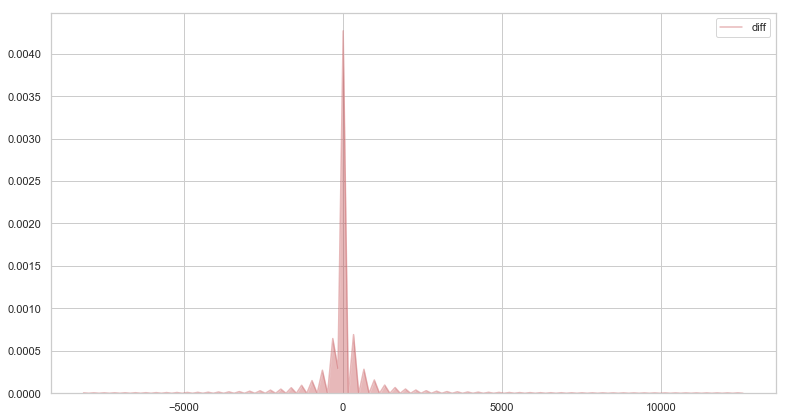

In [51]:
sns.kdeplot(xgb15.price.values - test.price1.values, shade=True, color="r", label="diff", alpha=.4)

# 训练与分析

In [30]:
dt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200000 entries, 0 to 199999
Data columns (total 60 columns):
SaleID                         200000 non-null int64
bodyType                       200000 non-null int32
fuelType                       200000 non-null int32
gearbox                        200000 non-null int32
isTrain                        200000 non-null int64
kilometer                      200000 non-null float64
notRepairedDamage              200000 non-null int32
power                          200000 non-null float64
price                          200000 non-null float64
v_0                            200000 non-null float64
v_1                            200000 non-null float64
v_10                           200000 non-null float64
v_11                           200000 non-null float64
v_12                           200000 non-null float64
v_13                           200000 non-null float64
v_14                           200000 non-null float64
v_2                  

In [32]:
print("=> 载入数据中...")
train, test, features, category_feature = load_data(dt=dt, m_type='xgb-model')
print("=> 建模特征列：", features)
print("=> 建模类别特征列：", category_feature)
print("=> 使用XGBoost建模...")

# 大小设置
sns.set(rc={'figure.figsize':(12,7)})
# 风格设置
sns.set_style("whitegrid")

=> 载入数据中...
=> 建模特征列： ['kilometer', 'power', 'v_0', 'v_1', 'v_10', 'v_11', 'v_12', 'v_13', 'v_14', 'v_2', 'v_3', 'v_4', 'v_5', 'v_6', 'v_7', 'v_8', 'v_9', 'salesDays', 'car_age', 'day_of_week', 'creatWeek_sin', 'creatWeek_cos', 'creatMonth_sin', 'creatMonth_cos', 'creatYearMonth_hit', 'creatYearMonth_hit_diff1', 'creatYearMonth_hit_huanbi', 'creatYearMonth_price', 'creatYearMonth_price_diff1', 'creatYearMonth_price_huanbi', 'creatDateStr_hit', 'creatDateStr_hit_diff1', 'creatDateStr_hit_huanbi', 'creatDateStr_price', 'creatDateStr_price_diff1', 'creatDateStr_price_huanbi', 'day', 'days_to_side', 'car_age_avg_price', 'regionCode_count', 'regionCode_price', 'regionCode_price_backet', 'name_count', 'name_price', 'name_price_backet', 'model_count', 'model_price', 'model_price_backet', 'brand_count', 'brand_price', 'brand_price_backet', 'bodyType', 'fuelType', 'gearbox', 'notRepairedDamage', 'holiday', 'creatDate_is_Weekend']
=> 建模类别特征列： ['bodyType', 'fuelType', 'gearbox', 'notRepairedDamag

In [33]:
mean_val = test['car_age_avg_price'].mean()
test['car_age_avg_price'].fillna(mean_val, inplace=True)
# 在测试集上缺失太多的数据，XGB上放弃
ignore_col = ['name_price', 'name_price_backet', 'regionCode_price', 'regionCode_price_backet']
features =  [i for i in features if i not in ignore_col]

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:6287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


XGB交叉验证...
[0]	train-mae:7.15857	test-mae:7.15855
[500]	train-mae:0.0826237	test-mae:0.120526
[1000]	train-mae:0.0626197	test-mae:0.117769
[1500]	train-mae:0.0498823	test-mae:0.11659
[2000]	train-mae:0.0410167	test-mae:0.115861
[2500]	train-mae:0.034577	test-mae:0.115359
[2999]	train-mae:0.0297483	test-mae:0.114988


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=0.75, gamma=0, learning_rate=0.05,
             max_delta_step=0, max_depth=8, min_child_weight=1, missing=None,
             n_estimators=3000, n_jobs=1, nthread=4, objective='reg:linear',
             random_state=0, reg_alpha=0.7, reg_lambda=0.01, scale_pos_weight=1,
             seed=202001, silent=True, subsample=0.9)

XGB训练...


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=0.75, gamma=0, learning_rate=0.05,
             max_delta_step=0, max_depth=8, min_child_weight=1, missing=None,
             n_estimators=3000, n_jobs=1, nthread=4, objective='reg:linear',
             random_state=0, reg_alpha=0.7, reg_lambda=0.01, scale_pos_weight=1,
             seed=202001, silent=True, subsample=0.9)

训练集MAE： 202.99484681683222
XGB迭代次数... 3000
XGB测试集预测...


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


XGB的特征重要性...


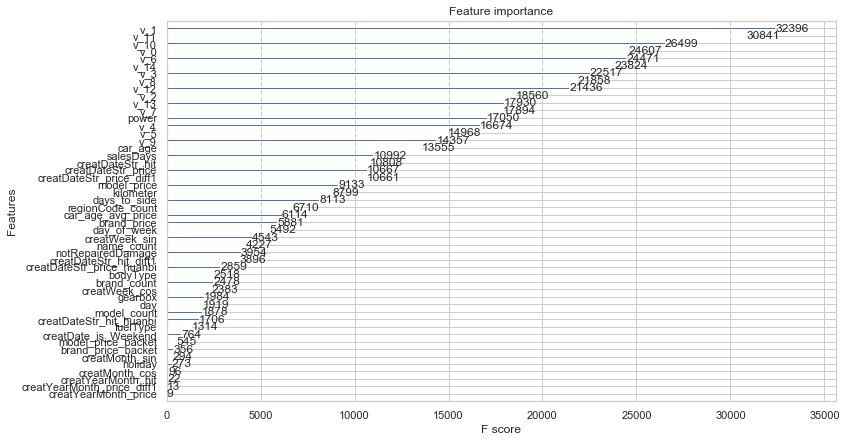

In [34]:
xgbRegr = XGBRegressor(
    learning_rate =0.05,
    n_estimators=3000,
    max_depth = 8,
    min_child_weight=1,
    reg_alpha= 0.7,
    reg_lambda= 0.01,
    gamma=0,
    subsample=0.9,
    colsample_bytree=0.75,
    objective= 'reg:linear',
    nthread=4,
    seed=202001)
print('XGB交叉验证...')
xgb_param = xgbRegr.get_xgb_params()
dtrain = xgb.DMatrix(train[features], train[goal])
cvresult = xgb.cv(xgb_param, 
                  dtrain,
                  num_boost_round=xgbRegr.get_params()['n_estimators'], 
                  nfold=3, 
                  metrics='mae',
                  early_stopping_rounds=200, 
                  verbose_eval=500, 
                  show_stdv=False, 
                  seed=202002, 
                  callbacks=None, 
                  shuffle=True)
xgbRegr.set_params(n_estimators=cvresult.shape[0])
print('XGB训练...')
xgbRegr.fit(train[features], train[goal], eval_metric='mae')
print('训练集MAE：', np.mean(abs(np.exp(xgbRegr.predict(train[features])) - 1 - np.exp(train[goal]) - 1)))
print('XGB迭代次数...', xgbRegr.n_estimators)
print('XGB测试集预测...')
price_pre2 = np.exp(xgbRegr.predict(test[features])) - 1
test['price2'] = price_pre2

#Plot feature importance 
print('XGB的特征重要性...')
plot_importance(xgbRegr)
plt.show()

In [299]:
xgb6 = pd.read_csv('result/sample_submit6.csv')
xgb12 = pd.read_csv('result/sample_submit12.csv')
xgb13 = pd.read_csv('result/sample_submit13.csv')
xgb14 = pd.read_csv('result/sample_submit14.csv')


np.mean(abs(xgb6.price.values-test.price2.values))
np.mean(abs(xgb12.price.values-test.price2.values))
np.mean(abs(xgb13.price.values-test.price2.values))
np.mean(abs(xgb14.price.values-test.price2.values))

179.73630528966905

252.57008526906966

211.1479294130516

269.74055372449874

In [341]:
submission = pd.DataFrame({myid: test[myid], goal: np.int64(test['price2'])})

In [342]:
submission.to_csv("./result/sample_submit.csv", index=False)

In [303]:
test['price3'] = test.price.values
test[['price', 'price2']].head(10)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,price,price2
150000,39131.921875,38232.484375
150001,15.985411,329.989410
150002,5594.168457,5726.291504
150003,13247.922852,11744.151367
150004,17.727194,648.953979
150005,2016.965576,1963.247070
150006,19.205526,4787.124512
150007,10456.128906,9737.985352
150008,2199.546875,2427.583740
150009,18.761173,2186.091064


In [308]:
test.loc[(test.name_price.isnull()) | (test.name_price_backet.isnull()) | 
     (test.regionCode_price.isnull()) | (test.regionCode_price_backet.isnull()), 'price3'] = test.loc[(test.name_price.isnull()) | (test.name_price_backet.isnull()) | 
     (test.regionCode_price.isnull()) | (test.regionCode_price_backet.isnull()), 'price2']



C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [310]:
test[['price', 'price2', 'price3']].head(10)

,price,price2,price3
150000,39131.921875,38232.484375,39131.921875
150001,15.985411,329.989410,329.989410
150002,5594.168457,5726.291504,5594.168457
150003,13247.922852,11744.151367,13247.922852
150004,17.727194,648.953979,648.953979
150005,2016.965576,1963.247070,2016.965576
150006,19.205526,4787.124512,4787.124512
150007,10456.128906,9737.985352,10456.128906
150008,2199.546875,2427.583740,2199.546875
150009,18.761173,2186.091064,2186.091064


In [311]:
np.mean(abs(xgb6.price.values-test.price2.values))
np.mean(abs(xgb12.price.values-test.price2.values))
np.mean(abs(xgb13.price.values-test.price2.values))
np.mean(abs(xgb14.price.values-test.price2.values))

179.73630528966905

252.57008526906966

211.1479294130516

269.74055372449874

In [312]:
np.mean(abs(xgb6.price.values-test.price3.values))
np.mean(abs(xgb12.price.values-test.price3.values))
np.mean(abs(xgb13.price.values-test.price3.values))
np.mean(abs(xgb14.price.values-test.price3.values))

247.96532695905685

306.5969119596672

271.46376182844165

312.6751711684227

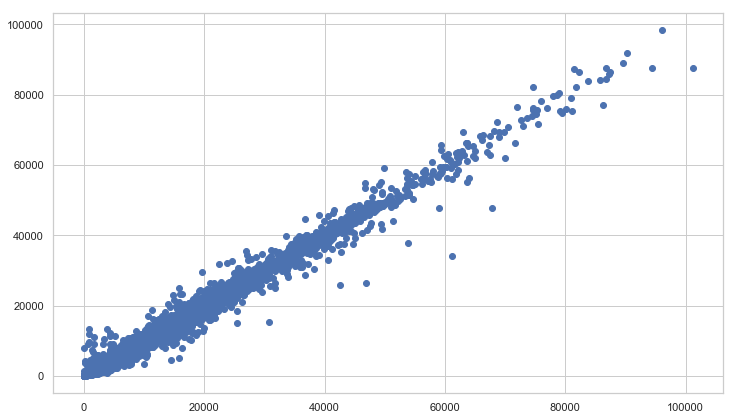

In [333]:
plt.scatter(test.price3, xgb6.price)

<Figure size 1280x800 with 0 Axes>

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


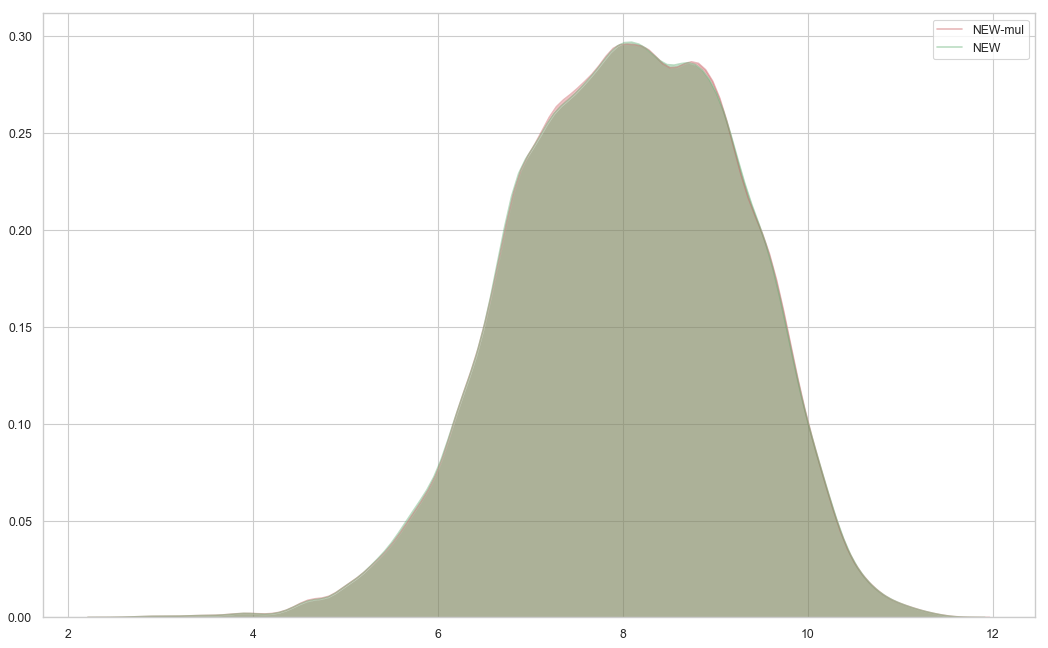

In [338]:

# Draw Plot
plt.figure(figsize=(16,10), dpi= 80)
# sns.kdeplot(np.log(train.price), shade=True, color="dodgerblue", label="True", alpha=.4)

# sns.kdeplot(np.log(xgb6.price), shade=True, color="orange", label="XGB6", alpha=.4)

# sns.kdeplot(np.log(xgb12.price), shade=True, color="orange", label="XGB12", alpha=.4)

# sns.kdeplot(np.log(xgb13.price), shade=True, color="orange", label="XGB13", alpha=.4)

# sns.kdeplot(np.log(xgb14.price), shade=True, color="r", label="XGB14", alpha=.4)

sns.kdeplot(np.log(test.price3), shade=True, color="r", label="NEW-mul", alpha=.4)

sns.kdeplot(np.log(test.price2), shade=True, color="g", label="NEW", alpha=.4)



# plt.axvline(x=6.8, ls="-",c="green")
# plt.axvline(x=7.2, ls="-",c="green")
# plt.axvline(x=7.5, ls="-",c="green")
# plt.axvline(x=7.8, ls="-",c="green")
# plt.axvline(x=10.11, ls="-",c="green")
# plt.axvline(x=10.36, ls="-",c="green")


# plt.xlim(10,12)

 
# Decoration
plt.legend()

In [331]:
mg = pd.DataFrame({'xgb6':xgb6.price, 'xgb12':xgb12.price, 'xgb13':xgb13.price, 'xgb14':xgb14.price, 
                   'new':test.price2.values, 'new-dul':test.price3.values})

In [332]:
mg.corr()

,xgb6,xgb12,xgb13,xgb14,new,new-dul
xgb6,1.000000,0.997755,0.998307,0.996765,0.998494,0.996392
xgb12,0.997755,1.000000,0.996968,0.995258,0.997011,0.995077
xgb13,0.998307,0.996968,1.000000,0.996504,0.997931,0.995917
xgb14,0.996765,0.995258,0.996504,1.000000,0.996143,0.994614
new,0.998494,0.997011,0.997931,0.996143,1.000000,0.996952
new-dul,0.996392,0.995077,0.995917,0.994614,0.996952,1.000000
